In [1]:
import re
import glob
import pandas as pd
import lightgbm as lgb
import shap
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data_dir = '../data/'

In [4]:
files = glob.glob(data_dir + '*.parquet')
files

['../data/etl_s1_1671504000_1671811200.parquet',
 '../data/etl_s1_1672431360_1672742400.parquet',
 '../data/etl_s1_1672742400_1673049600.parquet',
 '../data/etl_s1_1673049600_1673356800.parquet',
 '../data/etl_s1_1674585600_1674892800.parquet',
 '../data/etl_s1_1673356800_1673664000.parquet',
 '../data/etl_s1_1672118400_1672431360.parquet',
 '../data/etl_s1_1673971200_1674278400.parquet',
 '../data/etl_s1_1674278400_1674585600.parquet',
 '../data/etl_s1_1673664000_1673971200.parquet',
 '../data/etl_s1_1671811200_1672118400.parquet']

In [5]:
data = pd.read_parquet(files[0])

In [6]:
columns = data.columns

In [7]:
input_columns = []
for col in columns:
    if 'ETH-USD' in col:
        input_columns.append(col)

In [8]:
len(input_columns)

451

In [9]:
data = pd.DataFrame(columns=input_columns)
for file in files:
    df = pd.read_parquet(file, columns=input_columns)
    data = pd.concat([data, df])

In [10]:
data.shape

(3331699, 451)

In [11]:
target_column = 'ETH-USD:book_return_27sum>0.0065'

In [12]:
data[target_column] = data['ETH-USD:book_return_27sum'] > 0.0065

In [13]:
data[target_column] = data[target_column].replace({True:1.0, False:0.0})

In [14]:
data[target_column] = data[target_column].shift(-27)

In [15]:
data = data.drop([data.index[k] for k in range(-1, -28, -1)])

In [16]:
data.shape

(3331672, 452)

In [17]:
data.isna().sum().sum()

470475

In [18]:
data = data.fillna(0.)

In [19]:
X = data[input_columns]
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [20]:
Y = data[target_column]

In [21]:
sum(Y)

443.0

In [22]:
data.shape[0] / sum(Y)

7520.704288939052

In [23]:
def ts_train_test_split(X, Y, pct):
    n = X.shape[0]
    train_size = int(n * (1 - pct))
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    X_test = X[train_size:]
    Y_test = Y[train_size:]
    return (X_train, Y_train, X_test, Y_test)

In [24]:
X_train, Y_train, X_test, Y_test = ts_train_test_split(X, Y, 0.2)

In [25]:
### LGB Model

In [26]:
model = lgb.LGBMClassifier(learning_rate=0.05, class_weight={1.0 : 7520.0, 0.0 : 1.0})

In [27]:
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test), (X_train, Y_train)], eval_metric='l2')

[1]	training's l2: 0.225095	training's binary_logloss: 0.64312	valid_0's l2: 0.255792	valid_0's binary_logloss: 0.704735
[2]	training's l2: 0.203595	training's binary_logloss: 0.599757	valid_0's l2: 0.231212	valid_0's binary_logloss: 0.65556
[3]	training's l2: 0.184218	training's binary_logloss: 0.56035	valid_0's l2: 0.209056	valid_0's binary_logloss: 0.611065
[4]	training's l2: 0.166752	training's binary_logloss: 0.5244	valid_0's l2: 0.189154	valid_0's binary_logloss: 0.570774
[5]	training's l2: 0.150984	training's binary_logloss: 0.49145	valid_0's l2: 0.171175	valid_0's binary_logloss: 0.533943
[6]	training's l2: 0.136761	training's binary_logloss: 0.461185	valid_0's l2: 0.15499	valid_0's binary_logloss: 0.500281
[7]	training's l2: 0.123932	training's binary_logloss: 0.433319	valid_0's l2: 0.140408	valid_0's binary_logloss: 0.469403
[8]	training's l2: 0.112294	training's binary_logloss: 0.407455	valid_0's l2: 0.127218	valid_0's binary_logloss: 0.440882
[9]	training's l2: 0.101786	tra

[67]	training's l2: 0.000946365	training's binary_logloss: 0.020438	valid_0's l2: 0.00222021	valid_0's binary_logloss: 0.0251403
[68]	training's l2: 0.00089951	training's binary_logloss: 0.0195231	valid_0's l2: 0.00214486	valid_0's binary_logloss: 0.0240955
[69]	training's l2: 0.000851955	training's binary_logloss: 0.0186264	valid_0's l2: 0.00208015	valid_0's binary_logloss: 0.0231049
[70]	training's l2: 0.000811436	training's binary_logloss: 0.0177947	valid_0's l2: 0.00203031	valid_0's binary_logloss: 0.0222065
[71]	training's l2: 0.000777877	training's binary_logloss: 0.017024	valid_0's l2: 0.00199421	valid_0's binary_logloss: 0.0214046
[72]	training's l2: 0.000740242	training's binary_logloss: 0.0162522	valid_0's l2: 0.00194553	valid_0's binary_logloss: 0.0205701
[73]	training's l2: 0.000707846	training's binary_logloss: 0.0155305	valid_0's l2: 0.00190895	valid_0's binary_logloss: 0.0198041
[74]	training's l2: 0.000676867	training's binary_logloss: 0.0148422	valid_0's l2: 0.00186012

LGBMClassifier(class_weight={0.0: 1.0, 1.0: 7520.0}, learning_rate=0.05)

In [28]:
Y_predict = model.predict(X_test)
Y_predict

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
for i in range(Y_predict.shape[0]):
    y = Y_predict[i]
    t = Y_test.iloc[i]
    if y != t:
        print("{}: y={} t={}".format(i, y, t))

76339: y=0.0 t=1.0
76340: y=0.0 t=1.0
76341: y=0.0 t=1.0
76342: y=0.0 t=1.0
76343: y=0.0 t=1.0
76344: y=0.0 t=1.0
76345: y=0.0 t=1.0
76346: y=0.0 t=1.0
76347: y=0.0 t=1.0
87729: y=0.0 t=1.0
123961: y=0.0 t=1.0
123962: y=0.0 t=1.0
123963: y=0.0 t=1.0
123964: y=0.0 t=1.0
123965: y=0.0 t=1.0
123968: y=0.0 t=1.0
123969: y=0.0 t=1.0
123970: y=0.0 t=1.0
123971: y=0.0 t=1.0
123972: y=0.0 t=1.0
123973: y=0.0 t=1.0
123974: y=0.0 t=1.0
123975: y=0.0 t=1.0
123976: y=0.0 t=1.0
123977: y=0.0 t=1.0
123978: y=0.0 t=1.0
123979: y=0.0 t=1.0
123980: y=0.0 t=1.0
123981: y=0.0 t=1.0
123982: y=0.0 t=1.0
123983: y=0.0 t=1.0
123984: y=0.0 t=1.0
123985: y=0.0 t=1.0
185674: y=1.0 t=0.0
185675: y=1.0 t=0.0
185676: y=1.0 t=0.0
185677: y=1.0 t=0.0
185678: y=1.0 t=0.0
185679: y=1.0 t=0.0
185680: y=1.0 t=0.0
218647: y=1.0 t=0.0
218648: y=1.0 t=0.0
218649: y=1.0 t=0.0
218650: y=1.0 t=0.0
218651: y=1.0 t=0.0
218652: y=1.0 t=0.0
218653: y=1.0 t=0.0
218654: y=1.0 t=0.0
218655: y=1.0 t=0.0
218656: y=1.0 t=0.0
218657: y=

283455: y=1.0 t=0.0
283456: y=1.0 t=0.0
283457: y=1.0 t=0.0
283458: y=1.0 t=0.0
283459: y=1.0 t=0.0
283460: y=1.0 t=0.0
283461: y=1.0 t=0.0
283462: y=1.0 t=0.0
283463: y=1.0 t=0.0
283464: y=1.0 t=0.0
283465: y=1.0 t=0.0
283466: y=1.0 t=0.0
283467: y=1.0 t=0.0
283468: y=1.0 t=0.0
283469: y=1.0 t=0.0
283470: y=1.0 t=0.0
283471: y=1.0 t=0.0
283472: y=1.0 t=0.0
283473: y=1.0 t=0.0
283474: y=1.0 t=0.0
283475: y=1.0 t=0.0
283476: y=1.0 t=0.0
283483: y=1.0 t=0.0
283484: y=1.0 t=0.0
283485: y=1.0 t=0.0
283486: y=1.0 t=0.0
283487: y=1.0 t=0.0
283488: y=1.0 t=0.0
283489: y=1.0 t=0.0
283490: y=1.0 t=0.0
283491: y=1.0 t=0.0
283492: y=1.0 t=0.0
283493: y=1.0 t=0.0
283494: y=1.0 t=0.0
283495: y=1.0 t=0.0
283496: y=1.0 t=0.0
283497: y=1.0 t=0.0
283498: y=1.0 t=0.0
283499: y=1.0 t=0.0
283500: y=1.0 t=0.0
283501: y=1.0 t=0.0
283502: y=1.0 t=0.0
283503: y=1.0 t=0.0
283504: y=1.0 t=0.0
283505: y=1.0 t=0.0
283506: y=1.0 t=0.0
283507: y=1.0 t=0.0
283508: y=1.0 t=0.0
283509: y=1.0 t=0.0
283510: y=1.0 t=0.0


551448: y=0.0 t=1.0


In [30]:
for i in range(Y_predict.shape[0]):
    y = Y_predict[i]
    t = Y_test.iloc
    if y == t and y == 1.0:
        print("{}: y={} t={}".format(i, y, t))

In [31]:
sum(Y_test)

40.0

In [32]:
sum(Y_predict)

1087.0

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

TypeError: only integer scalar arrays can be converted to a scalar index

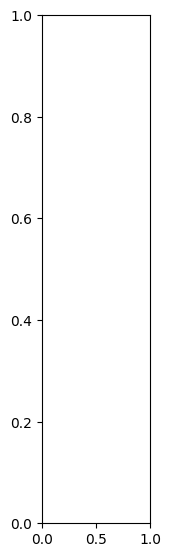

In [40]:
shap.summary_plot(shap_values, X_test)